# 1. Importación de librerías y carga de datos

In [ ]:
SCALED=True
STANDARIZED=False

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import pickle
import os

if SCALED:
  from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
  from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
DATASETS_FOLDER = os.path.join("TFM", "implementation", "datasets")
POSITIONS_FILE = os.path.join(DATASETS_FOLDER, "positions.csv")
df = pd.read_csv(POSITIONS_FILE)

columns = ['time(s)', 'vehicle_id', 'latitude(m)', 'longitude(m)', 'heading']
df = df[columns]
df.head()

,time(s),vehicle_id,latitude(m),longitude(m),heading
0,1.0,100,41.392245,2.162762,45.241513
1,1.0,101,41.390385,2.164237,133.252622
2,1.0,102,41.393895,2.162749,137.914783
3,1.0,103,41.390752,2.162845,225.740562
4,1.0,104,41.390913,2.163528,132.292083


In [ ]:
df = df.sort_values(['vehicle_id', 'time(s)'], ignore_index=True)
df.head()

,time(s),vehicle_id,latitude(m),longitude(m),heading
0,11.0,2,41.391721,2.162130,43.871783
1,12.0,2,41.391790,2.162216,43.871783
2,13.0,2,41.391775,2.162315,124.611142
3,14.0,2,41.391727,2.162396,131.690664
4,15.0,2,41.391681,2.162464,133.978174


In [ ]:
# Load dataset with vehicles colision
DATASET_COL = os.path.join(DATASETS_FOLDER, "collisions_1k.csv")
df_col = pd.read_csv(DATASET_COL)
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,2899,2884
1,8351,8507
2,6705,6636
3,7523,7414
4,651,541


In [ ]:
# Load dataset with vehicles no-colision
DATASET_NOCOL = os.path.join(DATASETS_FOLDER, "no_collisions_1k.csv")
df_nocol = pd.read_csv(DATASET_NOCOL)
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,6.0,85.0
1,29.0,61.0
2,38.0,266.0
3,38.0,300.0
4,38.0,315.0


## 2. Preprocesamiento de los datos

In [ ]:
# Drop registers when vehicle is stopped
# df = df.loc[df['latitude(m)'].shift() != df['latitude(m)']]
# df = df.reset_index(drop=True)
# print(df.shape)
# print(df.iloc[:, :])

In [ ]:
DATA_PREPARATION_FOLDER = os.path.join("TFM", "implementation",
                                       "data_preparation")
os.makedirs(DATA_PREPARATION_FOLDER, exist_ok=True)

In [ ]:
if SCALED:
  # MinMax scaler for features
  minmaxscaler = MinMaxScaler()
  scaled_features = minmaxscaler.fit_transform(df.iloc[:, 2:])

  # Save scaler for future uses
  minmaxscaler_file = os.path.join(DATA_PREPARATION_FOLDER,
                                   "minmaxscaler.pkl")
  with open(minmaxscaler_file, "wb") as f_scaler:
    pickle.dump(minmaxscaler, f_scaler)

  # Generate scaled dataset
  scaled_features = pd.DataFrame(
      scaled_features, columns=minmaxscaler.get_feature_names_out())
  df_scaled = pd.concat([df.iloc[:, :2], scaled_features], axis=1)
  print(df_scaled.shape)
  print(df_scaled.head())
elif STANDARIZED:
  # Standarization of features
  standardscaler = StandardScaler()
  stand_features = standardscaler.fit_transform(df.iloc[:, 2:])

  # Save standarscaler for future uses
  standardscaler_file = os.path.join(DATA_PREPARATION_FOLDER,
                                     "standardscaler.pkl")
  with open(standardscaler_file, "wb") as f_scaler:
    pickle.dump(standardscaler, f_scaler)

  # Generate standarized dataset
  stand_features = pd.DataFrame(
    stand_features, columns=standardscaler.get_feature_names_out())
  df_stand = pd.concat([df.iloc[:, :2], stand_features], axis=1)
  print(df_stand.shape)
  print(df_stand.head())

(7914246, 5)
   time(s)  vehicle_id  latitude(m)  longitude(m)   heading
0     11.0           2     0.661848      0.436445  0.121868
1     12.0           2     0.671440      0.445390  0.121868
2     13.0           2     0.669371      0.455645  0.346148
3     14.0           2     0.662619      0.464139  0.365814
4     15.0           2     0.656165      0.471120  0.372168


In [ ]:
# Generate list with vehicle_id for testing dataset
v1_col_set = set(df_col.loc[:, 'vehicle_id'])
v2_col_set = set(df_col.loc[:, 'victim_id'])
vehicle_col_set = v1_col_set | v2_col_set
print(len(vehicle_col_set))

v1_nocol_set = set(df_nocol.loc[:, 'v1'])
v2_nocol_set = set(df_nocol.loc[:, 'v2'])
vehicle_nocol_set = v1_nocol_set | v2_nocol_set
print(len(vehicle_nocol_set))

vehicle_id_test = vehicle_col_set | vehicle_nocol_set
print(len(vehicle_id_test))

2000
887
2584


## 3. Generación de ventanas

In [ ]:
# Input and output columns
INPUT_COL = ['time(s)', 'latitude(m)', 'longitude(m)', 'heading']
OUTPUT_COL = ['time(s)', 'latitude(m)', 'longitude(m)', 'heading']


class WindowGenerator():
  input_columns = []
  output_columns = []
  input_columns_filter = []
  output_columns_filter = []

  total_window_size = 0

  input_slice = None
  input_indices = []
  output_slice = None
  output_indices = []

  def __init__(self, input_width, output_width, offset_width, dataset,
               input_columns=None, output_columns=None):
    # Work out the input and output column filters.
    self.input_columns = input_columns
    if input_columns:
      self.input_columns_filter = [col in input_columns 
                                   for col in dataset.columns]

    self.output_columns = output_columns
    if output_columns:
      self.output_columns_filter = [col in output_columns 
                                   for col in dataset.columns]

    # Work out the window parameters.
    self.total_window_size = input_width + offset_width + output_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    output_start = input_width + offset_width
    self.output_slice = slice(output_start, None)
    self.output_indices = np.arange(self.total_window_size)[self.output_slice]


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Output indices: {self.output_indices}',
        f'Input column name(s): {self.input_columns}',
        f'Output column name(s): {self.output_columns}'])


  def split_window(self, dataset, shift):
    inputs_list, outputs_list = list(), list()

    for i in range(len(dataset)):
      start = len(dataset) - ((i+1)*shift)
      end = len(dataset) - (i*shift)
      if start < 0:
        break
      window_data = np.array(dataset[start:end], dtype=np.float128)

      # Gather input and output parts of the pattern
      inputs = window_data[self.input_slice, :]
      if self.input_columns_filter:
        inputs = inputs[:, self.input_columns_filter]
      inputs_list.append(inputs)

      outputs = window_data[self.output_slice, :]
      if self.output_columns_filter:
        outputs = outputs[:, self.output_columns_filter]
      outputs_list.append(outputs)

    return np.array(inputs_list, dtype=np.float128), \
     np.array(outputs_list, dtype=np.float128)


def make_windowed_dataset(dataset, input_width, output_width, offset_width,
                          shift, id_test_list, input_columns=None,
                          output_columns=None):
  X = np.empty((0, input_width, len(input_columns)-1), dtype=np.float128)
  y = np.empty((0, output_width, len(output_columns)-1), dtype=np.float128)
  X_test = np.empty((0, input_width, len(input_columns)-1), dtype=np.float128)
  y_test = np.empty((0, output_width, len(output_columns)-1), dtype=np.float128)
  vehicle_ids = []

  # Generate time window
  # df_vehicles = dataset.sort_values(by=['vehicle_id', 'time(s)'])
  time_window = WindowGenerator(
      input_width=input_width, output_width=output_width, offset_width=offset_width,
      dataset=dataset.drop('vehicle_id', axis=1),
      input_columns=input_columns, output_columns=output_columns)
  print(time_window)

  # Generate windowed dataset
  for id in dataset['vehicle_id'].unique():
    vehicle_df = (dataset[dataset['vehicle_id'] == id]
                  .drop('vehicle_id', axis=1))
    inputs, labels = time_window.split_window(vehicle_df, shift)
    if np.any(inputs) and np.any(labels):
      inputs = np.flip(inputs, axis=0)
      labels = np.flip(labels, axis=0)
      if id in id_test_list:
        if len(inputs) > 1:
          # Get n-1 training windows
          X = np.vstack((X, inputs[:-1, :, 1:])) # latitude, longitude and heading
          y = np.vstack((y, labels[:-1, :, 1:])) # latitude, longitude and heading

          # Get a testing window
          X_test = np.vstack((X_test, inputs[-1:, :, 1:]))
          y_test = np.vstack((y_test, labels[-1:, :, 1:]))

          # Generate list with testing vehicle ids
          vehicle_ids.append(id)
        else:
          # Get a testing window
          X_test = np.vstack((X_test, inputs[:, :, 1:]))
          y_test = np.vstack((y_test, labels[:, :, 1:]))

          # Generate list with testing vehicle ids
          vehicle_ids.append(id)
      else:
        # Get n training windows
        X = np.vstack((X, inputs[:, :, 1:])) # latitude, longitude and heading
        y = np.vstack((y, labels[:, :, 1:])) # latitude, longitude and heading

  return X, y, X_test, y_test, vehicle_ids


def train_val_split(X, y, val_size, filename=None):
  X_train, X_val, y_train, y_val = [], [], [], []

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size,
                                                    random_state=0)

  if filename:
    np.savez(filename,
             X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
  
  return X_train, X_val, y_train, y_val

### 3.1. Ventana no coincidente multi-step (input_step = 20s, output_step = 5s)

In [ ]:
# Window parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0
SHIFT=INPUT_WIDTH + OUTPUT_WIDTH + OFFSET_WIDTH

# Generate windows
if SCALED:
  X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
      df_scaled, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
      offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
      input_columns=INPUT_COL, output_columns=OUTPUT_COL)
elif STANDARIZED:
  X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
      df_stand, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
      offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
      input_columns=INPUT_COL, output_columns=OUTPUT_COL)
else:
  X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
      df, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
      offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
      input_columns=INPUT_COL, output_columns=OUTPUT_COL)

print("\nWindowed dataset dimesions:\nX: {}  y: {}\nX_test: {}  y_test: {}\n"
      .format(X.shape, y.shape, X_test.shape, y_test.shape))

# Save testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join(DATASETS_FOLDER, "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, "wb") as f_vehicle_ids:
  pickle.dump(vehicle_ids, f_vehicle_ids)

# Save testing dataset as compressed numpy file
if SCALED:
  test_file = os.path.join(DATASETS_FOLDER,
                           "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
  test_file = os.path.join(DATASETS_FOLDER,
                           "ventanas_no_coincidentes_test_stand.npz")
else:
  test_file = os.path.join(DATASETS_FOLDER,
                           "ventanas_no_coincidentes_test.npz")
np.savez(test_file, X_test=X_test, y_test=y_test)

# Generate training and validation datasets and save them as a compressed numpy
# file
if SCALED:
  ds_file = os.path.join(DATASETS_FOLDER,
                         "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
  ds_file = os.path.join(DATASETS_FOLDER,
                         "ventanas_no_coincidentes_train_val_stand.npz")
else:
  ds_file = os.path.join(DATASETS_FOLDER,
                         "ventanas_no_coincidentes_train_val.npz")
X_train, X_val, y_train, y_val = train_val_split(X, y, val_size=0.3,
                                                 filename=ds_file)

print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Output indices: [20 21 22 23 24]
Input column name(s): ['time(s)', 'latitude(m)', 'longitude(m)', 'heading']
Output column name(s): ['time(s)', 'latitude(m)', 'longitude(m)', 'heading']

Windowed dataset dimesions:
X: (309181, 20, 3)  y: (309181, 5, 3)
X_test: (2584, 20, 3)  y_test: (2584, 5, 3)

X_train: (216426, 20, 3)  y_train: (216426, 5, 3)
X_val: (92755, 20, 3)  y_val: (92755, 5, 3)


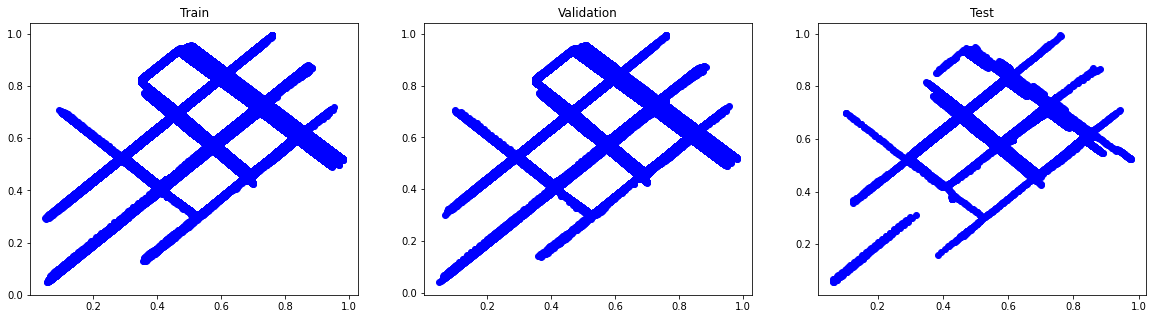

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(X_train[:, :, 0], X_train[:, :, 1], 'bo')
ax[0].title.set_text("Train")
ax[1].plot(X_val[:, :, 0], X_val[:, :, 1], 'bo')
ax[1].title.set_text("Validation")
ax[2].plot(X_test[:, :, 0], X_test[:, :, 1], 'bo')
ax[2].title.set_text("Test")
plt.show()

In [ ]:
print("X_train: ", X_train.min(axis=0).min(axis=0), X_train.max(axis=0).max(axis=0))
print("X_val:   ", X_val.min(axis=0).min(axis=0), X_val.max(axis=0).max(axis=0))
print("X_test:  ", X_test.min(axis=0).min(axis=0), X_test.max(axis=0).max(axis=0))

X_train:  [0.04861529 0.03973336 0.        ] [0.98135793 0.99455159 0.99999278]
X_val:    [6.05063420e-02 5.14526450e-02 5.59439553e-05] [0.98227279 0.99451787 0.99998066]
X_test:   [0.06247116 0.05498054 0.00132874] [0.97674785 0.99347871 0.99815087]
